## Table of contents:
* [Loading data](#loading-data)
* [Compute calibration](#compute-calibration)

In [8]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import scipy.integrate as integrate
import scipy.stats as stats
import scipy.optimize as optimize

import sys
sys.path.append('../core')
sys.path.append('..')

from core import data, erm
from overlaps import Overlaps, average_overlaps
import core.calibration
import utility


import gcmpyo3

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Below are the functions to compute the optimal $\lambda_{\rm error}$ and $\lambda_{\rm loss}$

In [9]:
def generalisation_loss_probit_teacher(teacher_square_norm, m, q, noise_variance):
    """
        It's still going to be with a logistic student
    """
    bound = 10.0
    teacher    = gcmpyo3.Probit(noise_variance = 0.0)
    student_Z0 = lambda y, omega : np.log(1 + np.exp(- y * omega))
    
    loss  = 0.0

    for y in [-1.0, 1.0]:
        tmp = integrate.quad(lambda xi : teacher.call_z0(y, m / np.sqrt(q) * xi, teacher_square_norm - m**2 / q + noise_variance) * student_Z0(y, np.sqrt(q) * xi) * stats.norm.pdf(xi, loc = 0.0, scale = 1.0), 
                               -bound, bound)
        loss  += tmp[0]

    return loss

def generalisation_error_probit_teacher(teacher_square_norm, m, q, noise_variance):
    return 1. / np.pi * np.arccos(m / (np.sqrt(q * (teacher_square_norm + noise_variance))))

In [10]:
def find_lambda_loss(sampling_ratio, noise_variance, teacher_square_norm = 1.0, lambda_min = 1e-4, lambda_max = 1.0):
    def to_optimize(lambda_):
        # tolerance for converrgence criterion in state evolution equations
        tolerance = 1e-4
        m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.erm_state_evolution_matching(sampling_ratio, noise_variance, lambda_, teacher_square_norm, "probit" , tolerance, True, False)
        return generalisation_loss_probit_teacher(teacher_square_norm, m, q, noise_variance)
    result = optimize.minimize_scalar(to_optimize, bounds = (lambda_min, lambda_max), method = 'bounded')
    return result.x

def find_lambda_error(sampling_ratio, noise_variance, teacher_square_norm = 1.0, lambda_min = 1e-4, lambda_max = 1.0):
    def to_optimize(lambda_):
        # tolerance for converrgence criterion in state evolution equations
        tolerance = 1e-4
        m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.erm_state_evolution_matching(sampling_ratio, noise_variance, lambda_, teacher_square_norm, "probit" , tolerance, True, False)
        return generalisation_error_probit_teacher(teacher_square_norm, m, q, noise_variance)
    result = optimize.minimize_scalar(to_optimize, bounds = (lambda_min, lambda_max), method = 'bounded')
    return result.x

### Plot for $\tau = 0.5$ <a class="anchor" id="loading-data"></a>

In [30]:
sigma = 0.5

alphas = np.linspace(0.5, 10, 50)
lambdas_loss = [ find_lambda_loss(alpha, sigma**2, 1.0) for alpha in alphas ]
lambdas_error= [ find_lambda_error(alpha, sigma**2, 1.0) for alpha in alphas ]

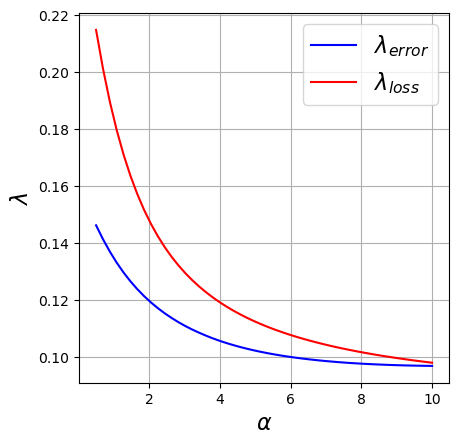

In [31]:
fig = plt.figure()
ax = fig.add_subplot()

plt.plot(alphas, lambdas_error, 'b', label='$\\lambda_{error}$')
try:
    plt.plot(alphas, lambdas_loss, 'r', label='$\\lambda_{loss}$')
except Exception as e:
    print(e)
    
ax.set_aspect(1./ax.get_data_ratio())

# plt.title(f'Optimal $\\lambda$ $\\sigma$ = {sigma}')

plt.xlabel('$\\alpha$', fontsize=16)
plt.ylabel('$\\lambda$', fontsize=16)
plt.grid()



plt.legend(fontsize=16)
plt.show()

### Compute overlaps

In [32]:
class Overlap:
    def __init__(self, m, q, v, mhat, qhat, vhat) -> None:
        self.m = m
        self.q = q
        self.v = v
        self.mhat = mhat
        self.qhat = qhat
        self.vhat = vhat

In [33]:
def compute_overlaps(alphas, lambdas, sigma):
    d = 500

    overlaps = []

    for (a, l) in zip(alphas, lambdas):
        overlaps.append(Overlap(*gcmpyo3.state_evolution.erm_state_evolution_matching(a, sigma**2, l, 1.0, "probit", 1e-4, True, False)))
    return overlaps

### Compute calibration <a class="anchor" id="compute-calibration"></a>

In [34]:
p = 0.75
delta_p = 0.05

In [49]:
overlaps_lambda_error = compute_overlaps(alphas, lambdas_error, sigma)
overlaps_lambda_loss = compute_overlaps(alphas, lambdas_loss, sigma)

calibration_lambda_error = [ core.calibration.compute_teacher_calibration(p, 1.0, o.q, o.m, sigma) for o in overlaps_lambda_error]
calibration_lambda_loss  = [ core.calibration.compute_teacher_calibration(p, 1.0, o.q, o.m, sigma) for o in overlaps_lambda_loss]

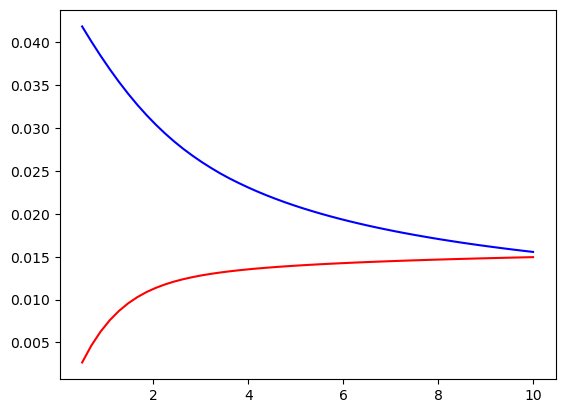

In [50]:
plt.plot(alphas, calibration_lambda_error, 'b', label='$\\lambda_{error}$')
plt.plot(alphas, calibration_lambda_loss, 'r', label='$\\lambda_{loss}$')
plt.grid()

In [48]:
# experimental
np.random.seed(0)

d = 500
ntest = 100000

wstar = np.random.normal(0.0, 1.0, d)
xtest = np.random.normal(0.0, 1.0, (ntest, d)) / np.sqrt(d)
ytest = np.sign(xtest @ wstar + np.random.normal(0.0, sigma, ntest))

exp_calibration_lambda_error, exp_calibration_lambda_loss = [], []

for i, sampling_ratio in enumerate(alphas):
    n = int(sampling_ratio * d)
    x = np.random.normal(0.0, 1.0, (n, d)) / np.sqrt(d)
    y = np.sign(x @ wstar + np.random.normal(0.0, sigma, n))
    lambda_error, lambda_loss = lambdas_error[i], lambdas_loss[i]

    what_error = erm.erm_logistic_regression(x, y, lambda_error)
    confidence_test_error = utility.sigmoid(xtest @ what_error)

    what_loss  = erm.erm_logistic_regression(x, y, lambda_loss)
    confidence_test_loss  = utility.sigmoid(xtest @ what_loss)

    # consider the indices where the proba is in [p - delta_p, p + delta_p]
    indices_error = np.where((confidence_test_error > p - delta_p) & (confidence_test_error < p + delta_p))[0]
    indices_loss  = np.where((confidence_test_loss  > p - delta_p) & (confidence_test_loss  < p + delta_p))[0]

    mean_teacher_error = np.mean(0.5 * (1.0 + ytest[indices_error]))
    mean_teacher_loss  = np.mean(0.5 * (1.0 + ytest[indices_loss]))

    calibration_lambda_error.append(p - mean_teacher_error)
    calibration_lambda_loss.append(p - mean_teacher_loss)


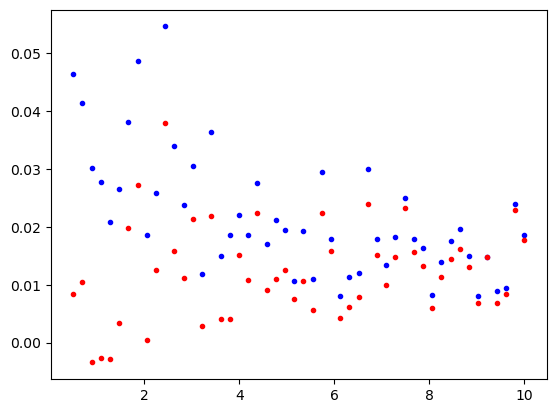

In [46]:
plt.scatter(alphas, calibration_lambda_error, color='b', label='$\\lambda_{error}$', marker='.')
plt.scatter(alphas, calibration_lambda_loss, color='r', label='$\\lambda_{loss}$', marker='.')

NameError: name 'teacher_cals_list' is not defined

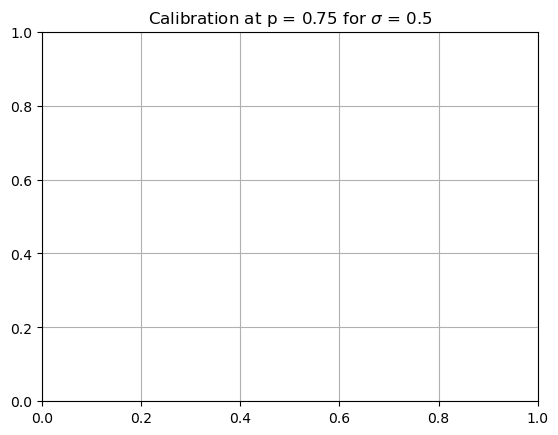

In [21]:


fig = plt.figure()
ax = fig.add_subplot()

plt.grid()
plt.title('Calibration at p = {:.2f} for $\\sigma$ = {}'.format(p, sigma))

plt.plot(alphas, teacher_cals_list, 'b', label='$\\lambda_{error}$')
plt.plot(alphas_loss, loss_teacher_cals_list, 'r', label='$\\lambda_{loss}$')

plt.errorbar(ex_alphas, full_exp_cals_list, yerr= np.array(std) / np.sqrt(ntrials), fmt='.', c='b', marker='x')
plt.errorbar(ex_alphas_loss, full_exp_loss_cals_list, yerr = np.array(loss_std) / np.sqrt(ntrials), fmt='.', marker='x', c='r')

legend = plt.legend(prop={'size':16})
legend.get_frame().set_alpha(1)
plt.xlabel('$\\alpha$', fontsize=16)
plt.ylabel('$\\Delta_p$', fontsize=16)
ax.set_aspect(1./ax.get_data_ratio())